In [ ]:
import sys
sys.path.append('../')
from functools import partial
from itertools import product
from tqdm import tqdm
from numpy.linalg import matrix_power

from qsimkit.spin import Nearest_Neighbour_1d
from qsimkit.trotter import pf, expH
from qiskit.quantum_info import SparsePauliOp, random_statevector, Statevector, Pauli, partial_trace, entropy
import matplotlib.pyplot as plt
from qsimkit.plot_config import *
set_fontsize(linewidth=2)
fig_dir, data_dir = './figs', './data'

# import os
# os.environ['XLA_FLAGS'] = '--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=16'
# import os
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=10'  # Use 6 CPU cores

def state_linear_magic(state):
    d = len(state)
    m = []
    pauligroup = [''.join(ops) for ops in product(['I','X','Y','Z'], repeat=int(np.log2(d)))]
    for j, paulistr in tqdm(enumerate(pauligroup), total=len(pauligroup), desc="Computing Paulis"):
        a = state.evolve(Pauli(paulistr))
        m1 = state.inner(a)
        m1 = np.sqrt(np.real(np.conj(m1)*m1))
        m.append(m1)
    magica = 1-d*np.average(np.power(m,4))
    return magica   

In [2]:
import jax
print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

# More detailed check
import jax.lib
# print(f"JAXlib version: {jax.lib.version.__version__}")

JAX version: 0.6.2
JAX backend: cpu
JAX devices: [CpuDevice(id=0)]


In [3]:
import numpy as np
from itertools import product
import jax
import jax.numpy as jnp

# Enable full 64-bit precision for accuracy
jax.config.update('jax_enable_x64', True)

# Pre-compile Pauli matrices for faster lookup
PAULI_MATRICES = {
    0: jnp.array([[1, 0], [0, 1]], dtype=jnp.complex128),      # I
    1: jnp.array([[0, 1], [1, 0]], dtype=jnp.complex128),      # X
    2: jnp.array([[0, -1j], [1j, 0]], dtype=jnp.complex128),   # Y
    3: jnp.array([[1, 0], [0, -1]], dtype=jnp.complex128),     # Z
}

@jax.jit
def apply_pauli_vectorized(state_vector, pauli_indices):
    """
    Highly optimized vectorized Pauli application.
    Applies all qubits in parallel instead of sequentially.
    """
    n = len(pauli_indices)
    result = state_vector.reshape([2] * n)
    
    # Process all qubits at once using einsum
    for qubit_idx in range(n):
        pauli_idx = pauli_indices[qubit_idx]
        
        # Get the appropriate Pauli matrix
        pauli_mat = jax.lax.switch(
            pauli_idx,
            [lambda: PAULI_MATRICES[0],
             lambda: PAULI_MATRICES[1],
             lambda: PAULI_MATRICES[2],
             lambda: PAULI_MATRICES[3]]
        )()
        
        # Create einsum string for this qubit
        # Contract along the qubit_idx dimension
        axes_str = ''.join([chr(97+i) for i in range(n)])  # abc...
        input_str = axes_str
        matrix_str = chr(97+qubit_idx) + chr(65+qubit_idx)  # e.g., 'aA' for first qubit
        output_str = axes_str.replace(chr(97+qubit_idx), chr(65+qubit_idx))
        
        einsum_str = f'{input_str},{matrix_str}->{output_str}'
        result = jnp.einsum(einsum_str, result, pauli_mat)
        
        # Rename back
        axes = list(range(n))
        axes[qubit_idx] = qubit_idx
        perm = [i if i != qubit_idx else axes.index(qubit_idx) for i in range(n)]
    
    return result.flatten()


@jax.jit  
def apply_pauli_fast(state_vector, pauli_indices):
    """
    Ultra-fast Pauli application using bit manipulation.
    Uses JAX control flow for JIT compatibility.
    """
    n = len(pauli_indices)
    N = 2**n
    result = state_vector
    
    # Process each qubit's Pauli operator
    for qubit_idx in range(n):
        pauli = pauli_indices[qubit_idx]
        bit_pos = n - 1 - qubit_idx
        mask = 1 << bit_pos
        indices = jnp.arange(N)
        
        # Define operations for each Pauli
        def identity_op(r):
            return r
        
        def x_op(r):
            new_indices = indices ^ mask
            return r[new_indices]
        
        def y_op(r):
            bits = (indices >> bit_pos) & 1
            new_indices = indices ^ mask
            phase = jnp.where(bits == 0, 1j, -1j)
            return phase * r[new_indices]
        
        def z_op(r):
            bits = (indices >> bit_pos) & 1
            phase = jnp.where(bits == 0, 1.0, -1.0)
            return phase * r
        
        # Apply the appropriate operator using switch
        result = jax.lax.switch(
            pauli,
            [identity_op, x_op, y_op, z_op],
            result
        )
    
    return result


@jax.jit
def compute_expectation_single_jax(state_vector, pauli_indices):
    """Compute expectation value for a single Pauli string."""
    transformed = apply_pauli_fast(state_vector, pauli_indices)
    exp_val = jnp.vdot(state_vector, transformed)
    return jnp.real(exp_val)


@jax.jit
def compute_expectation_batch_jax(state_vector, pauli_indices_batch):
    """Vectorized batch computation."""
    compute_all = jax.vmap(compute_expectation_single_jax, in_axes=(None, 0))
    return compute_all(state_vector, pauli_indices_batch)


def all_pauli_expectations_jax(state_vector, batch_size=None, show_progress=True):
    """
    Optimized computation with pre-generated indices and better batching.
    """
    try:
        from tqdm import tqdm
        has_tqdm = True
    except ImportError:
        has_tqdm = False
        if show_progress:
            print("Warning: tqdm not installed. Install with: pip install tqdm")
    
    n = int(np.log2(len(state_vector)))
    total_paulis = 4**n
    
    # Auto-tune batch size for float64/complex128
    if batch_size is None:
        state_size = len(state_vector) * 16  # 16 bytes per complex128 number
        max_batch_memory = 600 * 1024 * 1024  # 600 MB
        batch_size = max(1, min(total_paulis, max_batch_memory // state_size))
        batch_size = min(batch_size, 24576)  # Cap for float64
        if show_progress:
            print(f"Auto-selected batch size: {batch_size} (total: {total_paulis} Paulis)")
    
    # Convert to JAX array with full precision
    state_jax = jnp.array(state_vector, dtype=jnp.complex128)
    
    # Pre-generate ALL Pauli indices at once (much faster)
    pauli_to_idx = {'I': 0, 'X': 1, 'Y': 2, 'Z': 3}
    if show_progress and has_tqdm:
        print("Pre-generating Pauli indices...")
    
    all_pauli_indices = np.array(
        [[pauli_to_idx[c] for c in p] 
         for p in product(['I', 'X', 'Y', 'Z'], repeat=n)],
        dtype=np.int32
    )
    pauli_strings = [''.join(p) for p in product(['I', 'X', 'Y', 'Z'], repeat=n)]
    
    # Process in batches
    num_batches = (total_paulis + batch_size - 1) // batch_size
    
    # Pre-allocate result array with full precision
    all_exp_values = np.empty(total_paulis, dtype=np.float64)
    
    iterator = range(num_batches)
    if show_progress and has_tqdm:
        iterator = tqdm(iterator, desc=f"Computing {total_paulis} Paulis", 
                       unit="batch", ncols=100)
    
    for batch_idx in iterator:
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, total_paulis)
        
        # Get pre-computed batch
        pauli_indices_batch = jnp.array(all_pauli_indices[start_idx:end_idx])
        
        # Compute expectations for this batch
        batch_exp_values = compute_expectation_batch_jax(state_jax, pauli_indices_batch)
        all_exp_values[start_idx:end_idx] = np.array(batch_exp_values)
    
    # Create dictionary
    expectations = {pauli: exp_val for pauli, exp_val in zip(pauli_strings, all_exp_values)}
    
    return expectations


def state_magic_jax(state, batch_size=None, show_progress=True):
    """
    Optimized magic measure computation.
    
    Args:
        state: Qiskit Statevector object or numpy array
        batch_size: number of Paulis to process at once (auto-tuned if None)
        show_progress: whether to show tqdm progress bar
    
    Returns:
        magic: The magic measure M_2^lin(ψ)
    """
    # Get the state vector as numpy array
    if hasattr(state, 'data'):
        state_vector = state.data
    else:
        state_vector = state
    
    d = len(state_vector)
    
    # Compute all Pauli expectation values
    expectations = all_pauli_expectations_jax(state_vector, batch_size, show_progress)
    
    # Compute stabilizer purity P_2 using vectorized operations with full precision
    exp_values = np.fromiter(expectations.values(), dtype=np.float64, count=len(expectations))
    
    P_2 = np.sum(exp_values**4) / d
    magic = 1 - P_2
    
    return magic

In [5]:
n = 10 # 10
t = 10  
r = 50 # 100

dt = t/r
# H_model = 'MFI'
# hx, hy, Jx = 1, 0.9, 0.8
Jx, hx, hy = 1, 0.8, 0.9
print(f't={t}, r={r}, dt={dt}')

# init_state_str = '0'*n
init_state_str = '10'*(n//2)
init_state = Statevector.from_label(init_state_str).data

## QMFI
qmfi = Nearest_Neighbour_1d(n, hx=hx, hy=hy, Jx=Jx, pbc=False)
qmfi_xx_even = SparsePauliOp.from_sparse_list([*qmfi.xx_tuples[::2]], num_qubits=n).simplify()
qmfi_xx_odd = SparsePauliOp.from_sparse_list([*qmfi.xx_tuples[1::2]], num_qubits=n).simplify()
qmfi_x_terms = SparsePauliOp.from_sparse_list([*qmfi.x_tuples], num_qubits=n).simplify()
qmfi_y_terms = qmfi.y_terms
qmfi_H_list = [qmfi_x_terms, qmfi_y_terms, qmfi_xx_even, qmfi_xx_odd] 
qmfi_H_ordered = sum(qmfi_H_list)
qmfi_U_dt_ideal = expH(sum(qmfi_H_ordered), dt, use_jax=True)
qmfi_U_dt_appro = pf(qmfi_H_ordered, dt, 1, 1, use_jax=True)

current_state_ideal, current_state_appro = init_state, init_state
enten_list, magic_list, error_list = [], [], []
ideal_state_list = []
for d in range(r+1):
# for d in tqdm(range(r+1)):
    current_state_ideal = qmfi_U_dt_ideal @ current_state_appro
    current_state_appro = qmfi_U_dt_appro @ current_state_appro
    current_statevector = Statevector(np.array(current_state_ideal))
    ideal_state_list.append(current_statevector)
    enten = entropy(partial_trace(current_statevector, list(range(0, n-4))))
    enten_list.append(enten)
    # magic = state_linear_magic(current_statevector)
    magic = state_magic_jax(current_state_ideal)
    magic_list.append(magic)
    trot_err = np.linalg.norm(current_state_ideal - current_state_appro)
    error_list.append(trot_err)
    # print(f'step {d}, entropy {enten:.4f}, error {trot_err:.4e}')
    print(f'step {d}, entropy {enten:.4f}, magic {magic:.4f}, error {trot_err:.4e}')

# magic_list = [state_magic_jax(state) for state in ideal_state_list]

t=10, r=50, dt=0.2
Auto-selected batch size: 24576 (total: 1048576 Paulis)
Pre-generating Pauli indices...


Computing 1048576 Paulis: 100%|██████████████████████████████████| 43/43 [00:19<00:00,  2.24batch/s]


step 0, entropy 0.2245, magic 0.9478, error 2.0357e-01
Auto-selected batch size: 24576 (total: 1048576 Paulis)
Pre-generating Pauli indices...


Computing 1048576 Paulis: 100%|██████████████████████████████████| 43/43 [00:17<00:00,  2.40batch/s]


step 1, entropy 0.5125, magic 0.9814, error 2.2641e-01
Auto-selected batch size: 24576 (total: 1048576 Paulis)
Pre-generating Pauli indices...


Computing 1048576 Paulis: 100%|██████████████████████████████████| 43/43 [00:17<00:00,  2.47batch/s]


step 2, entropy 0.6866, magic 0.9802, error 1.9247e-01
Auto-selected batch size: 24576 (total: 1048576 Paulis)
Pre-generating Pauli indices...


Computing 1048576 Paulis: 100%|██████████████████████████████████| 43/43 [00:18<00:00,  2.27batch/s]


step 3, entropy 0.7639, magic 0.9890, error 1.8100e-01
Auto-selected batch size: 24576 (total: 1048576 Paulis)
Pre-generating Pauli indices...


Computing 1048576 Paulis:  84%|████████████████████████████▍     | 36/43 [00:16<00:03,  2.24batch/s]


KeyboardInterrupt: 

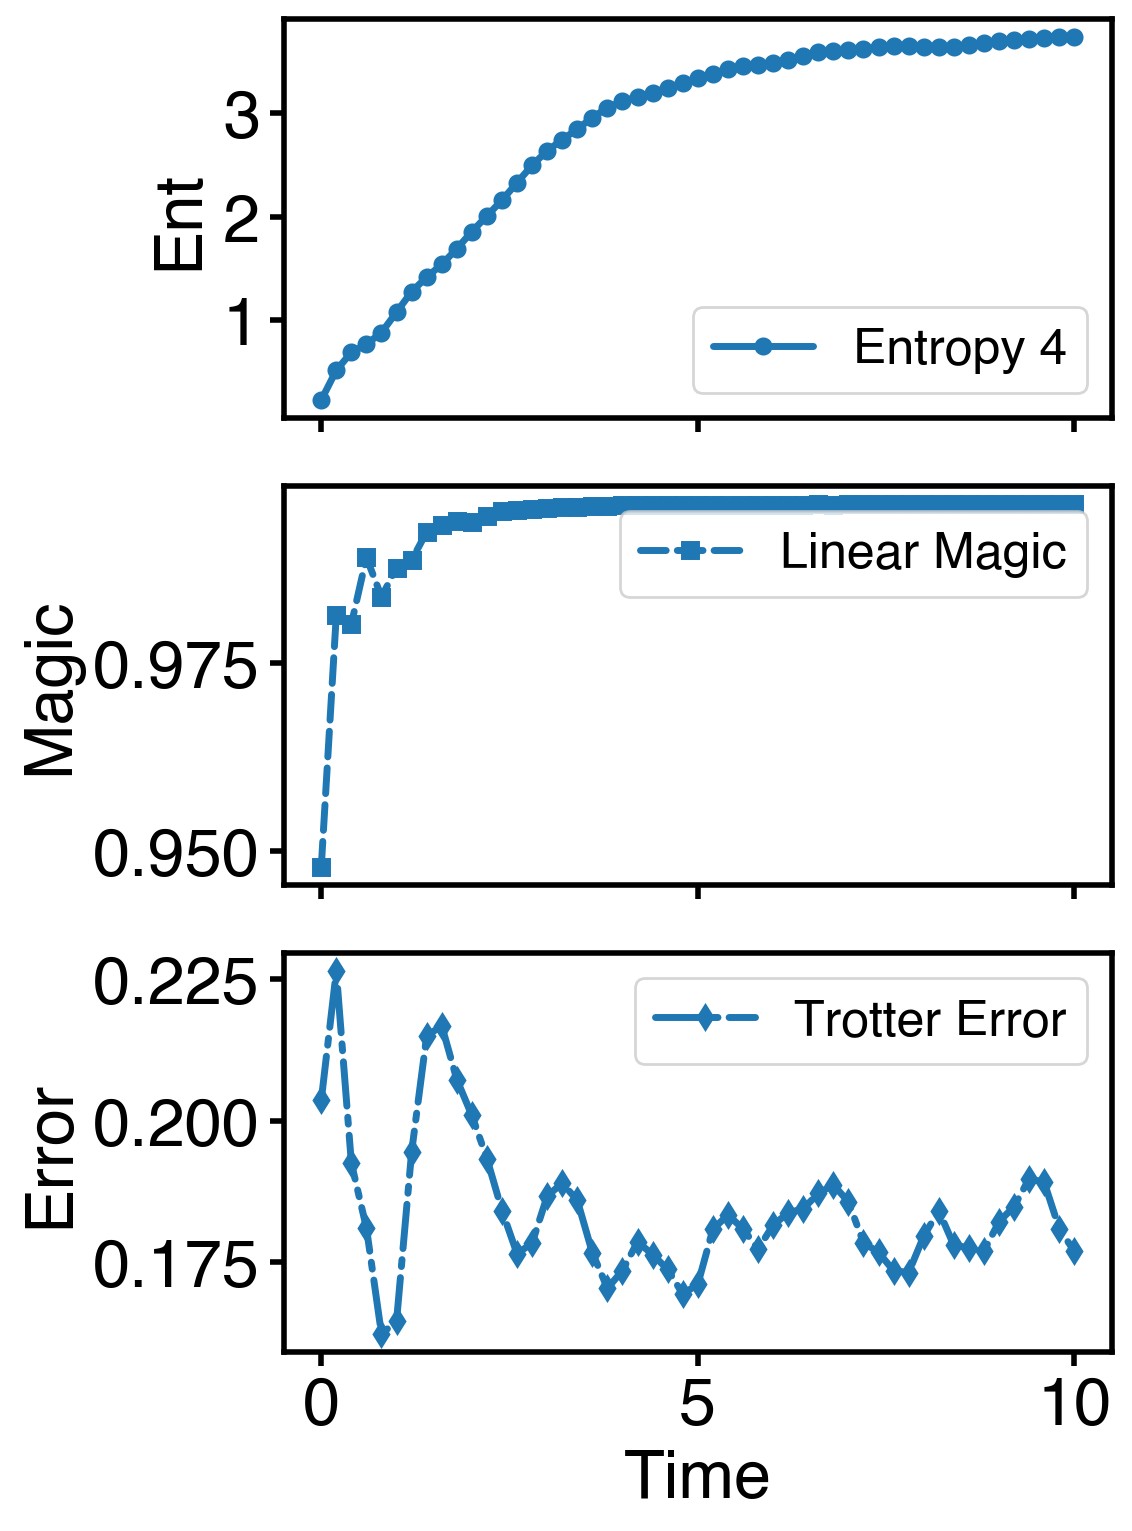

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True)
axes[0].plot(np.arange(r+1)*dt, enten_list, 'o-', label='Entropy 4', markersize=4)
axes[0].set_ylabel('Ent')
axes[1].plot(np.arange(r+1)*dt, magic_list, 's--', label='Linear Magic', markersize=4)
axes[1].set_ylabel('Magic')
axes[2].plot(np.arange(r+1)*dt, error_list, 'd-.', label='Trotter Error', markersize=4)
axes[2].set_ylabel('Error')
axes[2].set_xlabel('Time')
axes[0].legend(); axes[1].legend(); axes[2].legend()